In [19]:
import subprocess
import requests
import time
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

import matplotlib.pyplot as plt
import matplotlib as mtp
from matplotlib.colors import ListedColormap
import seaborn as sns
mtp.rcParams.update({'font.size':16})

import numpy as np
import pandas as pd
from random import *

seed(5000)

In [23]:
# make a call to FaaS platform to get runtime
def get_exectime(x, y): 
    # Configuring serverless function with suggested parameters
    deploy_command = f"gcloud functions deploy YOUR_FUNCTION_NAME \
        --source=YOUR_REQUEST_ADDRESS \
        --trigger-http \
        --runtime=python312 \
        --allow-unauthenticated \
        --entry-point=YOUR_ENTRY_POINT \
        --region=us-central1 \
        --gen2 \
        --memory={x}Mi \
        --cpu={y}"

    # Execute the command
    output = subprocess.run(deploy_command, shell=True, check=True, capture_output=True)
    if output.stdout:
        print(f"Update complete: Memory (MiB): {x}, vCPUs: {y}")
    
    # Make a HTTP request and get the execution time
    start_time = time.time()
    requests.get("YOUR_REQUEST_ADDRESS")
    end_time = time.time()
    exec_time = end_time - start_time
    return exec_time
    
def get_gcf_cost (exec_time, x, y):
    ''' Invocation Cost + Cost per memory + Cost per vcpu '''
    return 0.0000004 + (0.0000025 * (x / 1024.0) * exec_time) + (0.0000100 * (y * 2.4) * exec_time)

# use a static result to get the cost (execution time) of a given configuration
def get_cost(x, y):
    # Read the CSV file
    df = pd.read_csv('memory_benchmark_results.csv')

    # Find the matching pairs of x and y
    matching_rows = df[(df['Memory (MiB)'] == x) & (df['vCPUs'] == y)]

    # If there are no matching rows, return None
    if matching_rows.empty:
        print(f"No matching rows found for memory={x} and vcpu={y}")
        return None

    # Get the execution time and cost
    exec_time = matching_rows['Avg. Execution Time'].values[0]
    cost = matching_rows['Cost ($)'].values[0]

    # return exec_time, cost
    return cost


def next_finder (x, y):
    # configuration list
    CONFIGURATIONS = [
    (128, 0.083), (128, 0.167), (128, 0.333), (128, 0.583), (128, 1), (128, 2),
    (256, 0.083), (256, 0.167), (256, 0.333), (256, 0.583), (256, 1), (256, 2),
    (512, 0.083), (512, 0.167), (512, 0.333), (512, 0.583), (512, 1), (512, 2),
    (1024, 0.583), (1024, 1), (1024, 2), 
    (2048, 1), (2048, 2), (2048, 4),
    (4096, 1), (4096, 2), (4096, 4), (4096, 6), (4096, 8), 
    (8192, 2), (8192, 4), (8192, 6), (8192, 8), 
    (16384, 4), (16384, 6), (16384, 8)
    ]

    # Find min and max values for normalization
    max_memory = max(config[0] for config in CONFIGURATIONS)
    min_memory = min(config[0] for config in CONFIGURATIONS)
    max_vCPUs = max(config[1] for config in CONFIGURATIONS)
    min_vCPUs = min(config[1] for config in CONFIGURATIONS)  

    # Normalize
    norm_memory = (x - min_memory) / (max_memory - min_memory)
    norm_vCPUs = (y - min_vCPUs) / (max_vCPUs - min_vCPUs)

    # Distance calculation with normalized values
    distances = [
        np.linalg.norm(
            np.array([
                (config[0] - min_memory) / (max_memory - min_memory), 
                (config[1] - min_vCPUs) / (max_vCPUs - min_vCPUs)
            ]) - np.array([norm_memory, norm_vCPUs])
        )
        for config in CONFIGURATIONS  
    ]

    closest_index = np.argmin(distances)
    
    memory, vCPUs = CONFIGURATIONS[closest_index]
    return {'x': memory, 'y': vCPUs}

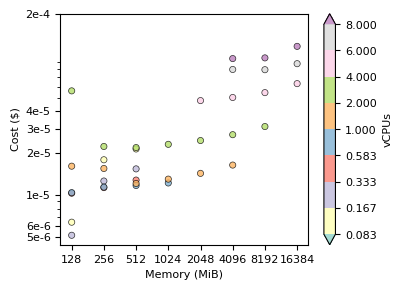

In [22]:
mtp.rcParams.update({'font.size':8})

# Load your data from the CSV file
df = pd.read_csv('memory_benchmark_results.csv')

# Extract the columns of interest
memory = df['Memory (MiB)']
vcpus = df['vCPUs']
cost = df['Cost ($)']

# Create a custom colormap
cmap = ListedColormap(sns.color_palette("Set3", 10))
bounds = [0.083, 0.167, 0.333, 0.583, 1, 2, 4, 6, 8]
norm = mtp.colors.BoundaryNorm(bounds, cmap.N, extend='both')

# 2D Scatter Plot (Memory vs. Execution Time)
plt.figure(figsize=(4, 3))
scatter = plt.scatter(memory, cost, c=vcpus, cmap=cmap, norm=norm, s=20, alpha=0.8, linewidths=0.5, edgecolors='black') 
plt.xlabel('Memory (MiB)')
plt.xscale('log', base=2)
plt.xticks(ticks=[128, 256, 512, 1024, 2048, 4096, 8192, 16384], labels=['128', '256', '512', '1024', '2048', '4096', '8192', '16384'])
plt.ylabel('Cost ($)')
plt.yscale('log')
plt.yticks(ticks=[5e-6, 6e-6, 1e-5, 2e-5, 3e-5, 4e-5, 2e-4], labels=['5e-6', '6e-6', '1e-5', '2e-5', '3e-5', '4e-5', '2e-4'])
plt.colorbar(scatter, label='vCPUs')
plt.show()

In [12]:
# define exploration space i.e. memory values 
pbounds = { 'x': (128, 16384), 'y': (0.083, 8)}

optimizer = BayesianOptimization(
    f=None,
    pbounds=pbounds,
    verbose=2,
    random_state=randint(128, 16384),
    allow_duplicate_points=True
)

# BO parameters 

acq_type = "ei"
xi_value = 0.001 # more exploitation 
alpha_value = 0.1
utility = UtilityFunction(kind=acq_type, xi=xi_value)

In [ ]:
# BO in action ...
counter = 1
total_samples = 94

init_list = [
    {'x': 128, 'y': 0.083},   
    {'x': 512, 'y': 0.333},   
    {'x': 1024, 'y': 1},
    {'x': 2048, 'y': 2},      
    {'x': 4096, 'y': 4},      
    {'x': 16384, 'y': 8}      
]

print("Initial points probing...\n")
for next_point in init_list:
    print(f"Next point to probe is: {next_point}\n")
    target = 1 / get_cost(**next_point)  
    print(f"Found the target value to be: {1 / target}\n")
    optimizer.set_gp_params(alpha=alpha_value)
    optimizer.register(params=next_point, target=target)

print("\nProbing complete, main optimization phase next...\n")


print("\nMain phase initiated...\n")

max_ei = -np.inf
convergence = False

while True:
    suggested_point = optimizer.suggest(utility)
    suggested_point_array = np.array([[suggested_point['x'], suggested_point['y']]]) # Convert the dictionary to a 2D array
    ei = utility.utility(suggested_point_array, optimizer._gp, optimizer.max['target'])
    if ei > max_ei:
        max_ei = ei
        print(f"Max EI: {max_ei}\n")
    if ei >= max_ei * 0.05 and convergence == False:
        next_point = next_finder(**suggested_point)
        print(f"Next point to probe is: {next_point}\n")
        target = 1 / get_cost(**next_point)
        print(f"Found the target value to be: {1 / target}\n")
        optimizer.set_gp_params(alpha=alpha_value)
        optimizer.register(params=next_point, target=target)
    else: # do not accept the suggestion
        convergence = True
        print("Use the best suggestion so far\n")
        print(f"Next point to probe is: {optimizer.max['params']}\n")
        print(f"Found the target value to be: {1 / optimizer.max['target']}\n")


    print(f"Samples so far: {counter + 6}\n")
    counter+=1
    if counter > total_samples:
        break
    
print(f"BEST: {1 / optimizer.max['target']} {optimizer.max['params']}\n\n")

In [ ]:
# Plot parameters
plt.rcParams.update({'font.size': 12})

# Initialize lists to store the data
sample = []
memory = []
vcpu = []
cost = []

# Read the file and extract data
with open('Your_output_text.txt', 'r') as f:
    lines = f.readlines()
    current_sample = 1  

    for line in lines:
        if "Next point to probe is:" in line:
            parts = line.split("{")[1].split("}")[0].split(",")
            memory.append(float(parts[0].split(":")[1]))
            vcpu.append(float(parts[1].split(":")[1]))
            sample.append(current_sample)
            current_sample += 1  
        elif "Found the target value to be:" in line:
            cost.append(float(line.split(":")[1]))

# Create DataFrames
df_3d = pd.DataFrame({'sample': sample, 'memory': memory, 'vcpu': vcpu})
df_2d = pd.DataFrame({'sample': sample, 'cost': cost})

# Create a custom colormap
cmap = ListedColormap(sns.color_palette("Set3", 10))
bounds = [0.083, 0.167, 0.333, 0.583, 1, 2, 4, 6, 8]
norm = mtp.colors.BoundaryNorm(bounds, cmap.N, extend='both')

# Create subplots for the two plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=300) 

# 2D scatter plot (Sample, Memory, vCPU)
scatter = ax1.scatter(df_3d['sample'], df_3d['memory'], c=df_3d['vcpu'], s=30, alpha=0.9, edgecolor='black', linewidth=0.5, cmap=cmap, norm=norm)
ax1.set_yscale('log', base=2)
ax1.set_yticks([128, 256, 512, 1024, 2048, 4096, 8192, 16384])
ax1.set_yticklabels(['128', '256', '512', '1024', '2048', '4096', '8192', '16384'])
ax1.set_xticks([0, 20, 40, 60, 80, 100])
ax1.set_xticklabels(['0', '20', '40', '60', '80', '100'])
ax1.set_aspect('auto')
ax1.set_xlabel('Samples', fontsize=14)
ax1.set_ylabel('Memory (MiB)', fontsize=14) 


# 2D scatter plot (Memory vs. Cost)
ax2.scatter(df_2d['sample'], df_2d['cost'], s=30, edgecolor='black', linewidth=0.5, color='royalblue')
ax2.set_yscale('log')
ax2.set_yticks([2e-5, 3e-5, 4e-5, 5e-5, 1e-4, 2e-4, 3e-4])
ax2.set_yticklabels(['2e-5', '3e-5', '4e-5', '5e-5', '1e-4', '2e-4', '3e-4'])
ax2.set_aspect('auto')
ax2.set_xlabel('Samples', fontsize=14)
ax2.set_ylabel('Cost ($)', fontsize=14)

# show the plot
plt.colorbar(scatter, label='vcpu')
plt.tight_layout()
plt.show()